In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, auc, roc_curve
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_score
from sklearn.model_selection import GridSearchCV
import optuna
import pickle
from sklearn.metrics import make_scorer, accuracy_score, classification_report, f1_score, confusion_matrix, roc_auc_score, precision_score, recall_score, average_precision_score


In [3]:
X_train = pd.read_csv('../Resources/Datasets/X_train.csv', index_col = 'building_id')
X_test = pd.read_csv('../Resources/Datasets/X_test.csv', index_col = 'building_id')
y_train = pd.read_csv('../Resources/Datasets/y_train.csv', index_col='building_id')
y_test = pd.read_csv('../Resources/Datasets/y_test.csv', index_col='building_id')

y_train = y_train - 1
y_test = y_test - 1
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()


In [17]:
xgb = XGBClassifier(objective='multi:softmax', num_class=3, n_estimators=100, max_depth=10, learning_rate=0.1, n_jobs=-1, verbosity=0)


xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)


cm = confusion_matrix(y_test, xgb.predict(X_test))
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.69      0.47      0.56      5025
           1       0.73      0.86      0.79     29652
           2       0.76      0.60      0.67     17444

    accuracy                           0.73     52121
   macro avg       0.72      0.64      0.67     52121
weighted avg       0.73      0.73      0.73     52121



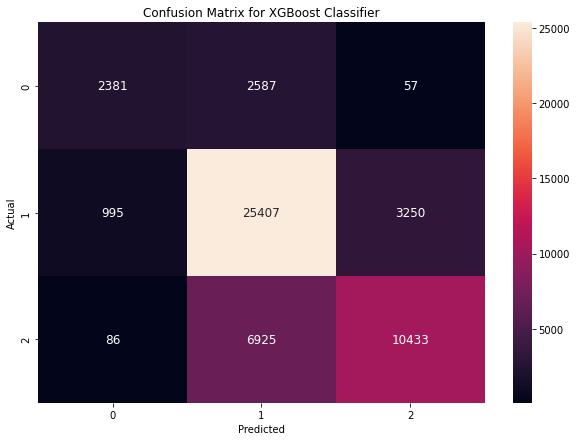

In [21]:
data = confusion_matrix(y_test, pred)
cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 12})
plt.title("Confusion Matrix for XGBoost Classifier")
plt.show()

In [27]:
def objective(trial): 

    params = {
    "objective": "multi:softmax",
    "num_class": 3,
    "n_estimators": 200,
    "verbosity": 0,
    "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
    "max_depth": trial.suggest_int("max_depth", 1, 10),
    "subsample": trial.suggest_float("subsample", 0.05, 1.0),
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
    "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    
    "njobs": -1
}
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    return cross_val_score(model, X_train, y_train, cv=3, scoring='f1_weighted').mean()
    
    
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-02-16 18:59:02,586] A new study created in memory with name: no-name-8fba5627-b3c5-4735-bc67-7a3e5dd2c048
[I 2024-02-16 19:03:15,608] Trial 0 finished with value: 0.6597078237569014 and parameters: {'learning_rate': 0.005716852792070349, 'max_depth': 6, 'subsample': 0.42814624971286985, 'colsample_bytree': 0.928485154898606, 'min_child_weight': 1}. Best is trial 0 with value: 0.6597078237569014.
[I 2024-02-16 19:05:48,804] Trial 1 finished with value: 0.6209517379741455 and parameters: {'learning_rate': 0.0041841511592990615, 'max_depth': 6, 'subsample': 0.7752677679486241, 'colsample_bytree': 0.47646923841110705, 'min_child_weight': 20}. Best is trial 0 with value: 0.6597078237569014.
[I 2024-02-16 19:06:22,521] Trial 2 finished with value: 0.6299461564588305 and parameters: {'learning_rate': 0.06738014765855146, 'max_depth': 2, 'subsample': 0.08175871404403526, 'colsample_bytree': 0.4263574617320884, 'min_child_weight': 1}. Best is trial 0 with value: 0.6597078237569014.
[I 2

In [28]:
trial = study.best_trial
params = trial.params

params 

{'learning_rate': 0.09789284012465421,
 'max_depth': 10,
 'subsample': 0.6063363852419413,
 'colsample_bytree': 0.8795479787311553,
 'min_child_weight': 4}

In [33]:
xgb = XGBClassifier(**params)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.69      0.47      0.56      5025
           1       0.73      0.86      0.79     29652
           2       0.76      0.60      0.67     17444

    accuracy                           0.74     52121
   macro avg       0.73      0.64      0.67     52121
weighted avg       0.74      0.74      0.73     52121



In [31]:
filename = '../Models/xgb_model.pkl'
pickle.dump(xgb, open(filename, 'wb'))

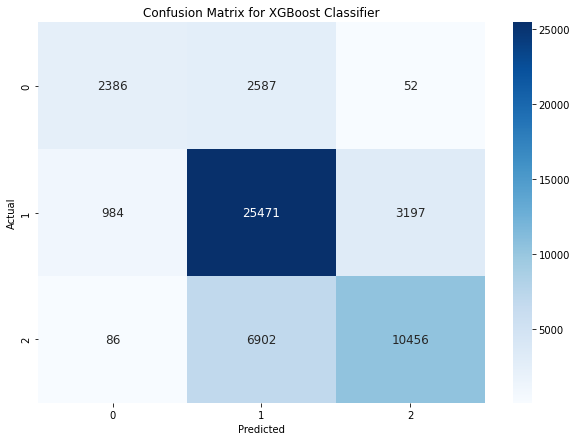

In [34]:
# visualize the confusion matrix with annotations

data = confusion_matrix(y_test, pred)
cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 12}, cmap='Blues')
plt.title("Confusion Matrix for XGBoost Classifier")
plt.show()


### Update XGB result

In [5]:
filename = '../Models/xgb_model.pkl'
xgb = pickle.load(open(filename, 'rb'))

result_df = pd.read_csv('../Resources/Datasets/results.csv', index_col=0)

y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)

result_df.loc['XGB'] = [accuracy_score(y_test, y_pred), 
                                   precision_score(y_test, y_pred, average='weighted'), 
                                   recall_score(y_test, y_pred, average='weighted'), 
                                   f1_score(y_test, y_pred, average='weighted'), 
                                   roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted'), 
                                   average_precision_score(y_test, y_pred_proba, average='weighted')]

In [7]:
result_df.to_csv('../Resources/Datasets/results.csv')

### Result After Preprocessing

In [2]:
X_train = pd.read_csv('../Resources/Datasets/X_train_processed.csv', header = None)
X_test = pd.read_csv('../Resources/Datasets/X_test_processed.csv', header = None)
y_train = pd.read_csv('../Resources/Datasets/y_train_processed.csv', index_col='building_id')
y_test = pd.read_csv('../Resources/Datasets/y_test_processed.csv', index_col='building_id')

y_train = y_train - 1
y_test = y_test - 1
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()



xgb = XGBClassifier(objective='multi:softmax', num_class=3, n_estimators=100, max_depth=10, learning_rate=0.1, n_jobs=-1, verbosity=0)


xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)


cm = confusion_matrix(y_test, xgb.predict(X_test))
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.63      0.39      0.48      5025
           1       0.67      0.85      0.75     29652
           2       0.68      0.44      0.53     17444

    accuracy                           0.67     52121
   macro avg       0.66      0.56      0.59     52121
weighted avg       0.67      0.67      0.65     52121



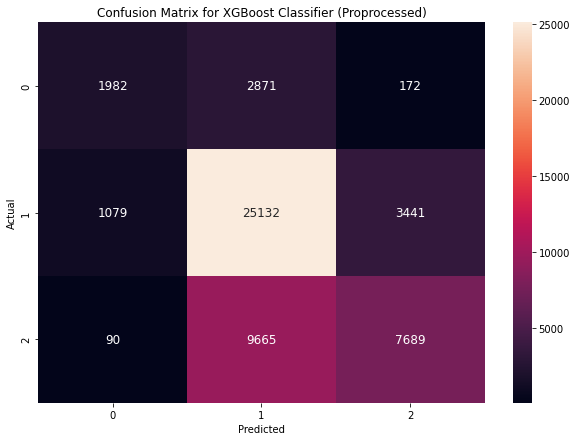

In [3]:
data = confusion_matrix(y_test, pred)
cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 12})
plt.title("Confusion Matrix for XGBoost Classifier (Proprocessed)")
plt.show()

In [4]:
def objective(trial): 

    params = {
    "objective": "multi:softmax",
    "num_class": 3,
    "n_estimators": 200,
    "verbosity": 0,
    "learning_rate": trial.suggest_float("learning_rate", 1e-3, 0.1, log=True),
    "max_depth": trial.suggest_int("max_depth", 1, 10),
    "subsample": trial.suggest_float("subsample", 0.05, 1.0),
    "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
    "min_child_weight": trial.suggest_int("min_child_weight", 1, 20),
    
    "njobs": -1
}
    model = XGBClassifier(**params)
    model.fit(X_train, y_train)
    return cross_val_score(model, X_train, y_train, cv=3, scoring='f1_weighted').mean()
    
    
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=30)

[I 2024-03-02 15:24:24,715] A new study created in memory with name: no-name-8b1bc49c-be6f-4073-bd85-4ece32df28e0
[I 2024-03-02 15:24:49,021] Trial 0 finished with value: 0.4131403636591935 and parameters: {'learning_rate': 0.012977643919880499, 'max_depth': 2, 'subsample': 0.1001498208469408, 'colsample_bytree': 0.2423756320787659, 'min_child_weight': 4}. Best is trial 0 with value: 0.4131403636591935.
[I 2024-03-02 15:27:05,481] Trial 1 finished with value: 0.43262984929639287 and parameters: {'learning_rate': 0.0010470691951235964, 'max_depth': 9, 'subsample': 0.7581482232302104, 'colsample_bytree': 0.20569049555082325, 'min_child_weight': 2}. Best is trial 1 with value: 0.43262984929639287.
[I 2024-03-02 15:27:39,526] Trial 2 finished with value: 0.42481850534473464 and parameters: {'learning_rate': 0.00959116100256886, 'max_depth': 3, 'subsample': 0.18433415094203565, 'colsample_bytree': 0.2770610010590359, 'min_child_weight': 7}. Best is trial 1 with value: 0.43262984929639287.
[

In [5]:
trial = study.best_trial
params = trial.params


xgb = XGBClassifier(**params)
xgb.fit(X_train, y_train)
pred = xgb.predict(X_test)

print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.63      0.38      0.48      5025
           1       0.67      0.85      0.75     29652
           2       0.68      0.44      0.53     17444

    accuracy                           0.67     52121
   macro avg       0.66      0.56      0.59     52121
weighted avg       0.67      0.67      0.65     52121



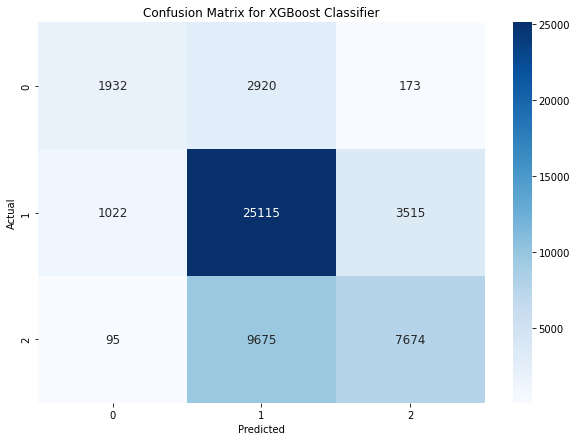

In [6]:
data = confusion_matrix(y_test, pred)
cm = pd.DataFrame(data, columns=np.unique(y_test), index = np.unique(y_test))
cm.index.name = 'Actual'
cm.columns.name = 'Predicted'
plt.figure(figsize = (10,7))
sns.heatmap(cm, annot=True, fmt="d", annot_kws={"size": 12}, cmap='Blues')
plt.title("Confusion Matrix for XGBoost Classifier")
plt.show()

In [9]:
result_df = pd.read_csv('../Resources/Datasets/results.csv', index_col=0)

y_pred = xgb.predict(X_test)
y_pred_proba = xgb.predict_proba(X_test)

# update results.csv, add a new row for the new model

result_df.loc['Preprocessed + XGB'] = [accuracy_score(y_test, y_pred), 
                                   precision_score(y_test, y_pred, average='weighted'), 
                                   recall_score(y_test, y_pred, average='weighted'), 
                                   f1_score(y_test, y_pred, average='weighted'), 
                                   roc_auc_score(y_test, y_pred_proba, multi_class='ovr', average='weighted'), 
                                   average_precision_score(y_test, y_pred_proba, average='weighted')]


result_df.to_csv('../Resources/Datasets/results.csv')